# Glaucoma detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

## Carga y procesamiento de los datos

In [2]:
datadir = 'dataset/glacucoma'
categorias = ['Normal', 'Avanzado', 'Temprano']

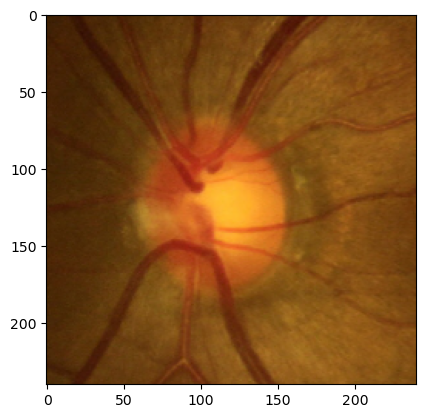

In [3]:
for cat in categorias:
    path = os.path.join(datadir, cat) #path to advanced or normal galucoma imgs e.g. 'dataset/glaucoma/Avanzado'
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))  #convertir imágenes en matrices 
        # Convertir de BGR a RGB
        img_array_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        plt.imshow(img_array_rgb)
        plt.show()
        break
    break

In [4]:
#todas las imágenes tienen el mismo tamaño: 240 pxl
print(img_array.shape)

(240, 240, 3)


In [5]:
#Si quisieramos cambiar el tamaño de las imágenes
#img_reshape = cv2.resize(img_array, (50, 50))
#plt.imshow(img_reshape, cmap='gray')

In [6]:
#Función para crear el dataset

datadir = 'dataset/glacucoma'  #Ruta de la carpeta con las imágenes
categorias = ['Normal', 'Avanzado', 'Temprano'] #Carpetas con las imágenes

datos = []

def crear_data():
    for categoria in categorias:
        path = os.path.join(datadir, categoria) 
        class_num = categorias.index(categoria)  #En este caso los índices serán: Normal=0, Avanzado=1, Temprano=2
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img)) 
            img_array_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB) #Convertir las imágenes al formato RGB
            datos.append([img_array_rgb, class_num])

In [7]:
crear_data()

In [8]:
len(datos)

1544

In [9]:
#mezclar los datos
import random

random.shuffle(datos)

In [10]:
#Creación de las variables x, y

x = []
y = []

for features, label in datos:
    x.append(features)
    y.append(label)

In [11]:
#Las entradas de la red neuronal debe ser una matriz, pero aquí x es una lista
#Convertimos x a un arreglo de numpy

x = [cv2.resize(image, (50, 50)) for image in x]  #cambiamos el tamaño de las imágenes para asegurarnos que sea igual para todas
x = np.array(x).reshape(-1, 50, 50, 3)

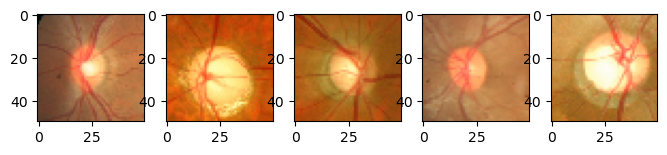

In [12]:
plt.figure(figsize=(8, 8))
for i in range(5):
    num = np.random.randint(1, 100)
    plt.subplot(1, 5, i+1)
    plt.imshow(x[num])
    i = i + 1
plt.show()

In [13]:
x.shape

(1544, 50, 50, 3)

In [14]:
#División del conjunto de datos

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4)

#Normalización de los datos

x_train = x_train/255
x_test = x_test/255

# mean = np.mean(x_train)
# std = np.std(x_train)

# x_train = (x_train - mean)/(std+1e-7)
# x_test = (x_test - mean)/(std+1e-7)

#conjuntos de validación
# (x_train, x_valid) = x_train[500:], x_train[:500]
# (y_train, y_valid) = y_train[500:], y_train[:500]

In [15]:
from keras.utils import to_categorical

y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)
#y_valid = to_categorical(y_valid)

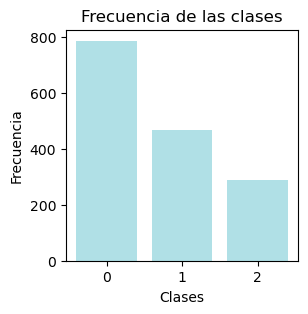

In [16]:
import seaborn as sn

plt.figure(figsize=(3, 3))
plt.subplot(1, 1, 1)
#sn.countplot(data=y, palette='viridis')
plt.hist(y, bins=[-0.5, 0.5, 1.5, 2.5], rwidth=0.8, align='mid', color='powderblue')
#plt.ylim(0, max(y.count(0), y.count(1), y.count(2)) + 1)
plt.title('Frecuencia de las clases')
plt.xlabel('Clases')
plt.ylabel('Frecuencia')
plt.show()

In [17]:
#datos de entrenamiento y prueba
tamaño = [x_train.shape[0], x_test.shape[0]]
tamaño

[926, 618]

## Creación del modelo

In [18]:
import tensorflow as tf
from tensorflow.keras import regularizers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
x.shape[1:]

(50, 50, 3)

In [20]:
modelo = Sequential()
base_filtros = 32

#Conv 1
modelo.add(Conv2D(2*base_filtros, (3, 3), activation='relu', padding='same', input_shape=x.shape[1:]))
#modelo.add(BatchNormalization())

#Conv 2
modelo.add(Conv2D(base_filtros, (3, 3), padding='same', activation='relu'))
#modelo.add(BatchNormalization())
modelo.add(MaxPooling2D((2,2)))
modelo.add(Dropout(0.2))

#Conv 3
modelo.add(Conv2D(2*base_filtros, (3, 3), padding='same', activation='relu'))
#modelo.add(BatchNormalization())
modelo.add(Dropout(0.2))

#Conv 4
modelo.add(Conv2D(2*base_filtros, (3, 3), padding='same', activation='relu'))
#modelo.add(BatchNormalization())
modelo.add(MaxPooling2D((2,2)))
modelo.add(Dropout(0.3))

#Conv 5
modelo.add(Conv2D(2*base_filtros, (3, 3), padding='same', activation='relu'))
#modelo.add(BatchNormalization())
modelo.add(Dropout(0.4))

#Conv 6
modelo.add(Conv2D(2*base_filtros, (3, 3), padding='same', activation='relu'))
#modelo.add(BatchNormalization())
modelo.add(MaxPooling2D((2,2)))
modelo.add(Dropout(0.4))

#Clasificación - Flatten

modelo.add(Flatten())
modelo.add(Dense(3, activation='softmax'))

In [21]:
#datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, heigth_shift_range=0.1, 
                   #horizontal_flip=True, vertical_flip=True)

In [22]:
#validation_data=( x_test,y_test_oh),

modelo.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = modelo.fit(x_train, y_train_oh, batch_size=32, epochs=40, shuffle=True) 

Epoch 1/40
29/29 [==============================] - 11s 310ms/step - loss: 0.9642 - accuracy: 0.5151
Epoch 2/40
29/29 [==============================] - 9s 312ms/step - loss: 0.7365 - accuracy: 0.6717
Epoch 3/40
29/29 [==============================] - 9s 324ms/step - loss: 0.7303 - accuracy: 0.6879
Epoch 4/40
29/29 [==============================] - 10s 333ms/step - loss: 0.6862 - accuracy: 0.6965
Epoch 5/40
29/29 [==============================] - 10s 353ms/step - loss: 0.6565 - accuracy: 0.7138
Epoch 6/40
29/29 [==============================] - 10s 355ms/step - loss: 0.6615 - accuracy: 0.7149
Epoch 7/40
29/29 [==============================] - 11s 366ms/step - loss: 0.6747 - accuracy: 0.7030
Epoch 8/40
29/29 [==============================] - 11s 372ms/step - loss: 0.6707 - accuracy: 0.7095
Epoch 9/40
29/29 [==============================] - 11s 370ms/step - loss: 0.6291 - accuracy: 0.7181
Epoch 10/40
29/29 [==============================] - 11s 376ms/step - loss: 0.6119 - accuracy

In [23]:
#loss, accuracy = modelo.evaluate(x_test, y_test_oh)

In [24]:
# modelo.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# history = modelo.fit(x_train, np.array(y_train), batch_size=8, epochs=15)

In [25]:
# loss, accuracy = modelo.evaluate(x_test, np.array(y_test))

In [26]:
y_pred = modelo.predict(x_test)

20/20 [==============================] - 2s 92ms/step


In [27]:
#Clasificación de las predicciones

def clasificacion(data):
    probs = []
    for i in range(data.shape[0]):
        valor = []
        for j in range(data.shape[1]):
            valor.append(data[i, j])
        valor_max = np.argmax(valor)
        if valor_max == 0:
            #probs.append(0)
            tipo = 'Normal'
            probs.append(tipo)
        if valor_max == 1:
            #probs.append(1)
            tipo = 'Avanzado'
            probs.append(tipo)
        if valor_max == 2:
            #probs.append(2)
            tipo = 'Temprano'
            probs.append(tipo)
            
    return probs

#Visualizar las n primeras predicciones

def vizualizar_prediccion(n):
    cl = clasificacion(y_pred)
    class_names = cl[:n]

    plt.figure(figsize=(8, 8))
    for i in range(n):
        plt.subplot(1, 5, i+1)
        plt.imshow(x_test[i])
        plt.xlabel(class_names[i])
        i = i + 1
    plt.show()


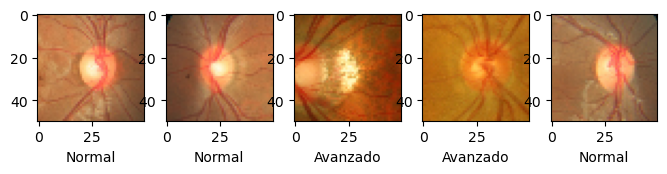

In [28]:
vizualizar_prediccion(5)

In [29]:
# prediccion = clasificacion(y_pred[0, :].reshape(1, 3))
# prediccion

In [30]:
#modelo.summary()

## Evaluación del modelo

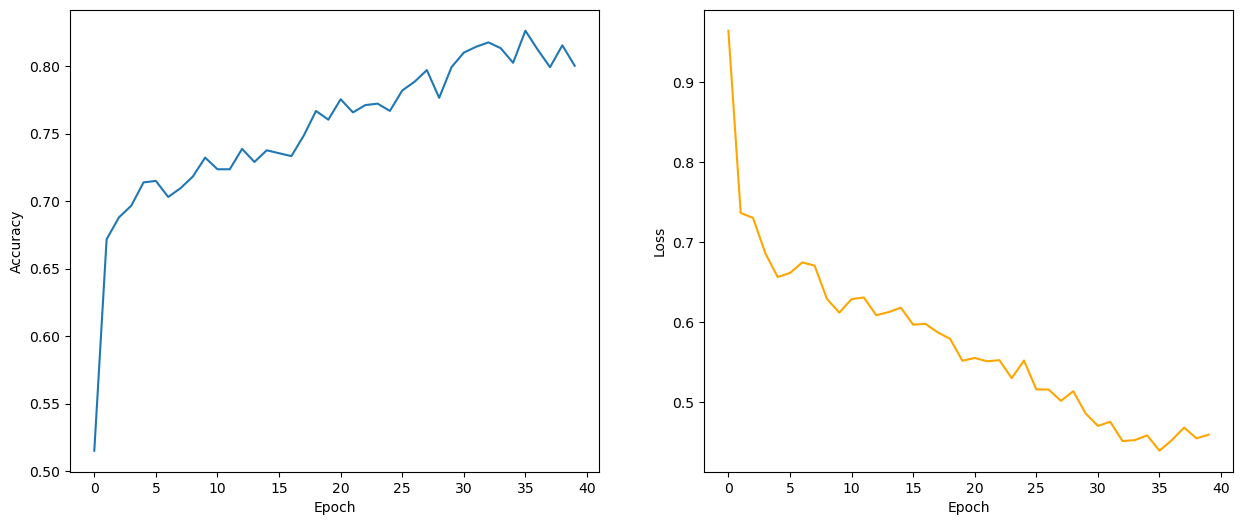

20/20 - 2s - loss: 0.5215 - accuracy: 0.7573 - 2s/epoch - 98ms/step


In [31]:
#Accuracy a través de las epoch

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
#plt.plot(history.history['val_accuracy'], label = 'Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'orange', label='Train')
#plt.plot(history.history['val_loss'], label = 'Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0.5, 1])
#plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = modelo.evaluate(x_test, y_test_oh, verbose=2)